# Science4Cast
### Forecasting AI trends in the next 5 years.

In [ ]:
CUTOFF = 1
CUTOFFTYPE = 'undirctf'#  ['dirctf,undirctf']
NNLAYERS = [100,100]
BATCHSIZE = 100
MVAVG = 500 # Moving average window
EDGES_USED = 1*(10**6)
FILTERUNCONNECTED = True
# TRAINING_FILE_TO_SAVE = 'new_file'
LOADFROMFILE = False
training_time = '00'

In [ ]:
import pickle
import random
import numpy as np
from scipy import sparse, special
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from datetime import date, timedelta, datetime
import time
# random.seed(42)

In [ ]:
# 2017 edges: 7652945
# 2014 edges: 2278611
# New edges: 7652945 - 2278611 = 5,374,334

NUM_OF_VERTICES=64719 # number of vertices of the semantic net
data_source_2017='CompetitionSet2017_3.pkl'
data_source_2014='TrainSet2014_3.pkl'
solutions_2014_file = 'TrainSet2014_3_solution.pkl'

full_dynamic_graph_sparse_2014,unconnected_vertex_pairs_2014,year_start_2014,years_delta = pickle.load( open( data_source_2014, "rb" ) )
full_dynamic_graph_sparse_2017,unconnected_vertex_pairs_2017,year_start_2017,years_delta = pickle.load( open( data_source_2017, "rb" ) )
solutions_2014 = pickle.load( open( solutions_2014_file, "rb" ) )

day_curr=date(2017,12,31)
day_origin=date(1990,1,1)

In [ ]:
def get_undir(matrix):
    return matrix + matrix.T

def get_matrix(pairs, number_of_vertices = 64719, convert_to_undirected = True):
    matrix = sparse.csr_matrix((np.ones(len(pairs)), (pairs[:,0], pairs[:,1])), shape=(number_of_vertices,number_of_vertices))
    if convert_to_undirected:
        matrix = get_undir(matrix)
    return matrix

def get_degs(matrix, convert_to_undirected = True):
    if convert_to_undirected:
        matrix = get_undir(matrix)
    return np.array(matrix.sum(0))[0]

def get_percentiles(arr, percentile = 1):
    percentiles = np.percentile(arr, np.arange(0,100,percentile))
    # print(percentiles)
    return percentiles

In [ ]:
VERBOSE = 0
def print_progress(print_output, importance_rank = 2, verbose = VERBOSE):
    '''
    The entire runtime receives a fixed VERBOSE value
    Prints the info while executing:
    2: Every thing
    1: Only completion of each stage.
    0: Nothing'''
    if importance_rank <= verbose:
        if type(print_output) == tuple:
            print(*print_output)
        else:
            print(print_output)

<a id='train'></a>
# Creating training data

In [ ]:
def create_training_data(full_graph,year_start,years_delta,filter_data = True, edges_used=100000,
                         vertex_degree_cutoff=10, connected_ratio = 0.5, return_graphs = False, unique_samples = False, weight = 3):
    """
    :param full_graph: Full graph, numpy array dim(n,3) [vertex 1, vertex 2, time stamp]
    :param year_start: year of graph
    :param years_delta: distance for prediction in years (prediction on graph of year_start+years_delta)
    :param edges_used: optional filter to create a random subset of edges for rapid prototyping (default: 500,000)
    :param vertex_degree_cutoff: optional filter, for vertices in training set having a minimal degree of at least vertex_degree_cutoff  (default: 10)
    :return:

    all_edge_list: graph of year_start, numpy array dim(n,2)
    unconnected_vertex_pairs: potential edges for year_start+years_delta
    unconnected_vertex_pairs_solution: numpy array with integers (0=unconnected, 1=connected), solution, length = len(unconnected_vertex_pairs)
    """
    # day_curr=date(2014,12,31)
    day_origin = date(1990,1,1)
    years=[year_start,year_start+years_delta]    
    
    all_G=[]
    all_edge_lists=[]
    all_sparse=[]
    for yy in years:
        print_progress(('Create Graph for ', yy),2, VERBOSE)
        day_curr=date(yy,12,31)
        # print('    All the edges before ', day_curr)
        all_edges_curr=full_graph[full_graph[:,2]<(day_curr-day_origin).days]
        adj_mat_sparse_curr = sparse.csr_matrix((np.ones(len(all_edges_curr)), (all_edges_curr[:,0], all_edges_curr[:,1])), shape=(NUM_OF_VERTICES,NUM_OF_VERTICES))
        G_curr=nx.from_scipy_sparse_matrix(adj_mat_sparse_curr, parallel_edges=False, create_using=None, edge_attribute='weight')

        all_G.append(G_curr)
        all_sparse.append(adj_mat_sparse_curr)
        all_edge_lists.append(all_edges_curr)

        print_progress(('    Done: Create Graph for ', yy),2, VERBOSE)
        print_progress(('    num of edges: ', G_curr.number_of_edges()),2, VERBOSE)


    if CUTOFFTYPE == 'dirctf':
        all_degs=np.array(all_sparse[0].sum(0))[0]
    ######## 
    # Modify degree calculation to adapt undirected graph
    if CUTOFFTYPE == 'undirctf':
        all_degs=np.array((all_sparse[0]+all_sparse[0].T).sum(0))[0]


    ## Create all edges to be predicted
    all_vertices=np.array(range(NUM_OF_VERTICES))

    unconnected_vertex_pairs=[]
    unconnected_vertex_pairs_solution=[]
# filtering the pairs by degree cutoff and ration of connected to unconnected
    if filter_data == True:
        large_deg_pairs = []
        for pair in all_edge_lists[1][:,0:2]: #full_graph[:,0:2]: >>> debugged for faster execution 20-11-2021
            if all_degs[pair[0]]>=vertex_degree_cutoff and all_degs[pair[1]]>=vertex_degree_cutoff:
                large_deg_pairs.append(pair)
        large_deg_pairs = np.array(large_deg_pairs)
        print_progress((f'    Cutoff size: {vertex_degree_cutoff}'),2, VERBOSE)       
        print_progress((f'    Potential pairs after cutoff: {large_deg_pairs.shape[0]}'),2, VERBOSE)

        vertex_large_degs=all_vertices[all_degs>=vertex_degree_cutoff] # use only vertices with degrees larger than 10.

        ################
        # enable or diable the unique edges here
        if unique_samples:
            large_deg_pairs = np.unique(large_deg_pairs, axis=0)
        print_progress((f'    Number of pairs: {large_deg_pairs.shape[0]}'),2, VERBOSE)
        
        # Shuffle the large deg pairs
        idxrnd = np.random.permutation(np.arange(len(large_deg_pairs)))
        large_deg_pairs = large_deg_pairs[idxrnd]

        time_start=time.time()
        # while len(unconnected_vertex_pairs)<edges_used:        
        #     v1,v2=random.sample(range(len(vertex_large_degs)), 2)
        for pair in large_deg_pairs:
            v1,v2 = pair[0], pair[1]

            edge_current = all_G[0].has_edge(v1,v2) # 0/1 (Boolean like): if v1 and v2 are connected now
            # edge_sol = all_G[1].has_edge(v1,v2) # 0/1 (Boolean like): if v1 and v2 will be connected after 3 years
            edge_sol = (all_G[1].get_edge_data(v1,v2)['weight'] > (weight-1)) if all_G[1].has_edge(v1, v2) else False

            if v1!=v2 and not edge_current:

                    ###### Filter unconnected pairs out 
                if FILTERUNCONNECTED == True:
                    if edge_sol: #(not edge_sol and random.random()<0.005) or :
                        unconnected_vertex_pairs.append((v1,v2))
                        unconnected_vertex_pairs_solution.append(edge_sol)

                        if len(unconnected_vertex_pairs)%10**6==0:
                            time_end=time.time()
                            print_progress(('    edge progress (',time_end-time_start,'sec): ',len(unconnected_vertex_pairs)/10**6,'M/',edges_used/10**6,'M'),2, VERBOSE)
                            time_start=time.time()
                        if len(unconnected_vertex_pairs)>= (edges_used*connected_ratio):
                            break
                else:
                    unconnected_vertex_pairs.append((v1,v2))
                    unconnected_vertex_pairs_solution.append(edge_sol)
                    if len(unconnected_vertex_pairs)%10**6==0:
                        time_end=time.time()
                        print_progress(('    edge progress (',time_end-time_start,'sec): ',len(unconnected_vertex_pairs)/10**6,'M/',edges_used/10**6,'M'),2, VERBOSE)
                        time_start=time.time()
        ##### generating negative sample (unconnected at end year)
        train_0_samples = []
        train_0_samples_solutions = []
        vertex_large_degs_list = [v for v in vertex_large_degs]

        while len(train_0_samples) < edges_used*(1-connected_ratio): #len(unconnected_vertex_pairs):
            v1,v2=random.sample(vertex_large_degs_list, 2)
            if not all_G[0].has_edge(v1,v2) and ((all_G[1].get_edge_data(v1,v2)['weight'] < weight) if all_G[1].has_edge(v1, v2) else True):
                train_0_samples.append([v1,v2])
                train_0_samples_solutions.append(0)
                if len(train_0_samples)%10**6==0:
                    print_progress((f'Negative sample size: {len(train_0_samples)}') ,2 , VERBOSE)                    
        unconnected_vertex_pairs = unconnected_vertex_pairs + train_0_samples
        unconnected_vertex_pairs_solution = unconnected_vertex_pairs_solution + train_0_samples_solutions
    #######
    # end of filtered data selection
    if filter_data == False:
        # idxrnd = np.random.permutation(np.arange(len(all_edge_lists[1])))
        # pairs = all_edge_lists[1][:,0:2][idxrnd]
        vertex_large_degs=all_vertices[all_degs>=vertex_degree_cutoff] # use only vertices with degrees larger than 10.
        vertex_large_degs_list = [v for v in vertex_large_degs]
        all_vertices_list = [v for v in all_vertices]
        while len(unconnected_vertex_pairs) < edges_used: #len(unconnected_vertex_pairs):
            v1,v2=random.sample(vertex_large_degs_list, 2)

 
        # for pair in pairs:
        #     v1,v2 = pair[0], pair[1]

            if v1!=v2 and not all_G[0].has_edge(v1,v2):
                unconnected_vertex_pairs.append((v1,v2))
                temp_sol = (all_G[1].get_edge_data(v1,v2)['weight'] > (weight-1)) if all_G[1].has_edge(v1, v2) else False
                unconnected_vertex_pairs_solution.append(temp_sol)

                # if len(unconnected_vertex_pairs)%10**5==0:
                #     time_end=time.time()               
                #     print_progress(('    edge progress (',time_end-time_start,'sec): ',len(unconnected_vertex_pairs)/10**6,'M/',edges_used/10**6,'M'),2, VERBOSE)
                #     time_start=time.time()
                # if len(unconnected_vertex_pairs)>= (edges_used):
                #     break
    #########
    # end of no filter data selection   
    print_progress(f'Data of year: {year_start}',1,VERBOSE)
    print_progress(('Number of unconnected vertex pairs for prediction: ', len(unconnected_vertex_pairs_solution)) ,1, VERBOSE)
    print_progress(('Number of vertex pairs that will be connected: ' , sum(unconnected_vertex_pairs_solution)) ,1, VERBOSE)
    print_progress(('Ratio of vertex pairs that will be connected: ' , sum(unconnected_vertex_pairs_solution)/len(unconnected_vertex_pairs_solution)),1, VERBOSE)
    
    unconnected_vertex_pairs=np.array(unconnected_vertex_pairs, dtype= 'int32')
    unconnected_vertex_pairs_solution=np.array(list(map(int, unconnected_vertex_pairs_solution)))
    all_edge_lists=all_edge_lists[0]
    
    if return_graphs:
        return all_edge_lists, unconnected_vertex_pairs, unconnected_vertex_pairs_solution, all_G
    else:
        return all_edge_lists, unconnected_vertex_pairs, unconnected_vertex_pairs_solution

In [ ]:
def create_training_data_strong(full_graph,year_end,years_delta,filter_data = True, edges_used=100000,
                         vertex_degree_cutoff=10, connected_ratio = 0.5, return_graphs = False, unique_samples = False, weight = 3):

    # day_curr=date(2014,12,31)
    day_origin = date(1990,1,1)
    # year_end = 2020
    # years=[year_end-5,year_end-3,year_end-1,year_end]    

    all_delta = [10,5,3,1,0]
    all_weights = [1,3,5,10,25]
    years=[year_end-5,year_end-3,year_end-1,year_end] 
    years = [(year_end-i) for i in all_delta]
    results = []

    all_G=[]
    all_edge_lists=[]
    all_sparse=[]
    for yy in years:
        print('Create Graph for ', yy)
        day_curr=date(yy,12,31)
        # print('    All the edges before ', day_curr)
        all_edges_curr=full_graph[full_graph[:,2]<(day_curr-day_origin).days]
        adj_mat_sparse_curr = sparse.csr_matrix((np.ones(len(all_edges_curr)), (all_edges_curr[:,0], all_edges_curr[:,1])), shape=(NUM_OF_VERTICES,NUM_OF_VERTICES))
        G_curr=nx.from_scipy_sparse_matrix(adj_mat_sparse_curr, parallel_edges=False, create_using=None, edge_attribute='weight')

        all_G.append(G_curr)
        all_sparse.append(adj_mat_sparse_curr)


        print('    Done: Create Graph for ', yy)
        print('    num of edges: ', G_curr.number_of_edges())

    all_edge_lists=all_edges_curr


    #################
    #################
    for gg_index in range(len(all_G)-1):
        for weight in all_weights:

            if CUTOFFTYPE == 'dirctf':
                all_degs=np.array(all_sparse[gg_index].sum(0))[0]
            ######## 
            # Modify degree calculation to adapt undirected graph
            if CUTOFFTYPE == 'undirctf':
                all_degs=np.array((all_sparse[gg_index]+all_sparse[gg_index].T).sum(0))[0]


            ## Create all edges to be predicted
            all_vertices=np.array(range(NUM_OF_VERTICES))

            unconnected_vertex_pairs=0
            unconnected_vertex_pairs_solution=0
        # filtering the pairs by degree cutoff and ration of connected to unconnected
            if filter_data == True:
                large_deg_pairs = []
                for pair in all_edge_lists[:,0:2]: #full_graph[:,0:2]: >>> debugged for faster execution 20-11-2021
                    if all_degs[pair[0]]>=vertex_degree_cutoff and all_degs[pair[1]]>=vertex_degree_cutoff:
                        large_deg_pairs.append(pair)
                large_deg_pairs = np.array(large_deg_pairs)
                print(f'    Cutoff size: {vertex_degree_cutoff}')       
                print(f'    Potential pairs after cutoff: {large_deg_pairs.shape[0]}')

                vertex_large_degs=all_vertices[all_degs>=vertex_degree_cutoff] # use only vertices with degrees larger than 10.

                ################
                # enable or diable the unique edges here
                if unique_samples:
                    large_deg_pairs = np.unique(large_deg_pairs, axis=0)
                print(f'    Number of pairs: {large_deg_pairs.shape[0]}')
                
                # Shuffle the large deg pairs
                # idxrnd = np.random.permutation(np.arange(len(large_deg_pairs)))
                # large_deg_pairs = large_deg_pairs[idxrnd]

                time_start=time.time()
                # while len(unconnected_vertex_pairs)<edges_used:        
                #     v1,v2=random.sample(range(len(vertex_large_degs)), 2)
                for pair in large_deg_pairs:
                    v1,v2 = pair[0], pair[1]

                    edge_current = all_G[gg_index].has_edge(v1,v2) # 0/1 (Boolean like): if v1 and v2 are connected now
                    # edge_sol = all_G[1].has_edge(v1,v2) # 0/1 (Boolean like): if v1 and v2 will be connected after 3 years
                    edge_sol = (all_G[-1].get_edge_data(v1,v2)['weight'] > (weight-1)) if all_G[-1].has_edge(v1, v2) else False

                    if v1!=v2 and not edge_current:

                            ###### Filter unconnected pairs out 
                        if FILTERUNCONNECTED == True:
                            if edge_sol: #(not edge_sol and random.random()<0.005) or :
                                unconnected_vertex_pairs +=1
                                unconnected_vertex_pairs_solution += 1

                        else:
                            unconnected_vertex_pairs += 1
                            unconnected_vertex_pairs_solution += 1
                            if len(unconnected_vertex_pairs)%10**6==0:
                                time_end=time.time()
                                # print('    edge progress (',time_end-time_start,'sec): ',len(unconnected_vertex_pairs)/10**6,'M/',edges_used/10**6,'M')
                                time_start=time.time()
            results.append([all_delta[gg_index], weight, unconnected_vertex_pairs])
    return results

In [ ]:
NUM_OF_VERTICES=64719
year_start_train = 2020
years_delta = 3
edges_used = 10**3
vertex_degree_cutoff = 1
results = create_training_data_strong(full_dynamic_graph_sparse_2020,year_start_train,
                                                    years_delta,
                                                    edges_used=edges_used,
                                                    vertex_degree_cutoff=vertex_degree_cutoff,
                                                    filter_data=True,
                                                    connected_ratio = 0.5)


# Breaking down the adjacency matrix to multiple chunks and calculating its square few rows at a time

In [ ]:
def calculate_v_secs(sparse_mat, sorted_v, sec_number = 1000):
    '''
    Calculates the start and end indices of each section of v_list that corresponds to a section of matrix in the divided matrix
    '''
    mat_size = sparse_mat.shape[0]
    sec_width = mat_size//sec_number

    if mat_size % sec_width != 0:
      list_lims = np.empty([sec_number+1,2], dtype = int)
    else:
      list_lims = np.empty([sec_number,2], dtype = int)

    list_lims[:] = -1 # np.nan

    for sec_index in range(sec_number):
      sec_start = sec_index*sec_width
      sec_end = sec_start + sec_width
      if sec_start <= sorted_v[:,0].max():
        list_sec_lims = np.where(np.logical_and(sorted_v[:,0]>=sec_start, sorted_v[:,0]<sec_end))[0] 
        if list_sec_lims.size !=0:
          list_lims[sec_index,0] = list_sec_lims[0]
          # By adding a "1" end itself is not included. As in v[a:b], last selected index is b-1
          list_lims[sec_index,1] = list_sec_lims[-1]+1
        else:
          list_lims[sec_index,0] = -1 # np.nan
          list_lims[sec_index,1] = -1 # np.nan

      else:
        break

    if mat_size % sec_width != 0:
      sec_start = sec_number*sec_width
      sec_end = mat_size # incorrect <<< sorted_v[:,0].max()
      if sec_start <= sorted_v[:,0].max():
        list_sec_lims = np.where(np.logical_and(sorted_v[:,0]>=sec_start, sorted_v[:,0]<sec_end))[0] 
        if list_sec_lims.size !=0:
          list_lims[sec_number,0] = list_sec_lims[0]
          list_lims[sec_number,1] = list_sec_lims[-1]+1
    list_lims = np.array(list_lims)
    # indices of sorted vlist, sorted vlist, sorting back indices
    #sort_index
    print_progress(('Vlist limits calculated.') ,2, VERBOSE)
    return list_lims

In [ ]:
# breaks matrix to row sections

def matrix_sec(sparse_mat, vlist, sec_number=1000):
    # there might be a small remaining sec at the end so the total secs will be sec_number + 1
    sort_index = np.argsort(vlist[:,0])
    sorted_v = vlist[sort_index]
    sort_back = np.argsort(sort_index)

    v_list_lims = calculate_v_secs(sparse_mat,sorted_v, sec_number)

    mat_size = sparse_mat.shape[0]
    FR = np.array(sparse_mat.sum(0))[0]
    FF = []
    MF = []


    sec_width = mat_size//sec_number
    if mat_size % sec_width > 0:
        total_sec_number = sec_number + 1
    else:
      total_sec_number = sec_number
    
    for sec_index in range(total_sec_number):

        start_row = sec_index*sec_width
        if sec_index < total_sec_number - 1:
            end_row = start_row + sec_width
        else:
            end_row = mat_size

        mat_sec = sparse_mat[start_row:end_row]
        mat_square_sec = mat_sec*sparse_mat
        # FF_sec = mat_square_sec.sum(1)  debugged version below
        FF_sec = mat_square_sec.sum(0)
        FF.append(FF_sec)      

        # Checking if the section indices exists in vlist (sorted vlist)

        if v_list_lims[sec_index,0] > -1:
            for index, pair in enumerate(sorted_v[v_list_lims[sec_index,0] : v_list_lims[sec_index,1]]):
                MF.append(mat_square_sec[pair[0]-sec_index*sec_width,pair[1]])
        del(mat_square_sec)

        if mat_size % sec_width != 0:
            start_row = sec_number*sec_width
            end_row = mat_size         
    
    # FF = np.concatenate([np.array(sec) for sec in FF])   debugged version is below
    FF = np.concatenate([np.array(sec) for sec in FF], axis = 0).sum(axis=0)
    FF = np.array(FF)
    FF = FF.reshape(FF.shape[0],)

    # Sorting MF back to original order
    MF = np.array(MF)
    MF = MF[sort_back]
    print_progress(('FR, FF, MF calculated.') ,2, VERBOSE)
    return(FR, FF, MF)

In [ ]:
# Calculating graph features - matrix break-down is used due to memory usage limits
def compute_all_properties(all_sparse,FR,FF,CLE,MF,ii,v1,v2):
    """
    Computes hand-crafted properties for one vertex in vlist
    """
    all_properties=[]
    for i in range(len(FR)):
        
        all_properties.append(FR[i][v1])
        all_properties.append(FR[i][v2])
        all_properties.append(FF[i][v1])
        all_properties.append(FF[i][v2])

        # all_properties.append(CLE[i][v1])
        # all_properties.append(CLE[i][v2])

        all_properties.append(MF[i][ii])

    return all_properties

def compute_all_properties_of_list(all_sparse,vlist, minmaxscale=True):

    time_start=time.time()
    FR = []
    FF = []
    CLE = []
    MF = []

    for index, mat_snapshot in enumerate(all_sparse):
        mat = mat_snapshot + mat_snapshot.T

        # Generates the graph object to calculate centerality
        # GG = nx.from_scipy_sparse_matrix(mat, parallel_edges=False, create_using=None, edge_attribute='weight')
        # print_progress((f'Graph-{index+1} generated'),2,VERBOSE)
        # CLE_temp = nx.eigenvector_centrality(GG)
        # CLE_temp = np.fromiter(CLE_temp.values(), dtype='float32', count=len(CLE_temp))
        # CLE_temp = CLE_temp - CLE_temp.min() 
        # if CLE_temp.max()>0:
        #     CLE_temp=CLE_temp/CLE_temp.max()
        CLE.append(np.zeros(NUM_OF_VERTICES))
        # print_progress((f'CLE-{index+1} generated'),2,VERBOSE)
        # print_progress((f'CLE-{index+1} min: {CLE_temp.min()} max: {CLE_temp.max()} mean: {CLE_temp.mean()}'),2,VERBOSE)

        FR_temp, FF_temp, MF_temp = matrix_sec(mat, vlist, sec_number = 10)

        ## Friends (degrees)
        # FR_temp = np.log(FR_temp+1)
        if FR_temp.max()>0 and minmaxscale:
            print(f'FR_max_{index}: {FR_temp.max()}')
            FR_temp=FR_temp/FR_temp.max()
        FR.append(FR_temp)

        ## Friends of Friends (total shared neiboughrs)
        # FF_temp = np.log(FF_temp+1)
        if FF_temp.max()>0 and minmaxscale:
            FF_temp=FF_temp/FF_temp.max()
        FF.append(FF_temp)

        # MF_temp = np.log(MF_temp+1)
        if MF_temp.max()>0 and minmaxscale:
            MF_temp = MF_temp/MF_temp.max()
        MF.append(MF_temp)


    FRmax = max([i.max() for i in FR])
    FFmax = max([i.max() for i in FF])
    MFmax = max([i.max() for i in MF])

    # FR = [i/FRmax for i in FR]
    # FF = [i/FFmax for i in FF]
    # MF = [i/MFmax for i in MF]
    """
    Computes hand-crafted properties for all vertices in vlist
    """

    all_properties=[]
    print_progress(('    Computed all matrix squares, ready to ruuuumbleeee...'),2,VERBOSE)

    all_properties = np.zeros([len(vlist), len(all_sparse)*5], dtype='float32')
    for ii in range(len(vlist)):
        vals=compute_all_properties(all_sparse,
                                    FR,
                                    FF,
                                    CLE,
                                    MF,
                                    ii,
                                    vlist[ii][0],
                                    vlist[ii][1])

        # all_properties.append(vals)
        all_properties[ii] = vals
        if ii%10**5==0:
            print_progress(('compute features: (',time.time()-time_start,'sec) ',ii/10**6,'M/',len(vlist)/10**6,'M'),2)
            time_start=time.time()
    print_progress('Feature generation completed.',1,VERBOSE)
    return all_properties

In [ ]:
# Generate training batches

def data_gen(data_train0, data_train1, batch_size=1000000):
  data_train0 = np.array(data_train0)
  data_train1 = np.array(data_train1)
  y_batch = []
  x_batch = []
  for i in range(batch_size//2):
      for output, data in enumerate([data_train0, data_train1]):
          rndid = np.random.randint(0, len(data), 1)
          x_batch.append(data[rndid][0])
          y_batch.append(output)
  return np.array(x_batch), np.array(y_batch)

def data_gen_rnd(data_train0, data_train1, batch_size=1000000, ratio = 0.5):
  data_train0 = np.array(data_train0)
  data_train1 = np.array(data_train1)
  y_batch = []
  x_batch = []
  for i in range(batch_size):
      if random.random() > ratio:
          rnd_output_id = 0
      else:
          rnd_output_id = 1
      data = [data_train0, data_train1][rnd_output_id]
      rndid = np.random.randint(0, len(data), 1)
      x_batch.append(data[rndid][0])
      y_batch.append(rnd_output_id)
  return np.array(x_batch), np.array(y_batch)  
    

In [ ]:
# EDGES_USED = 10*(10**6)
VERBOSE = 2

number_of_years = 3
number_of_months = 1
time_snapshots = 3
# year_start_train = 2002
# year_start_test = 2005
raw_data_connected_ratio = 0.5

edges_used=1000*(10**3) # Best would be to use all vertices, to create more training data. But that takes long and requires huge amount of memory. So here we use a random subset.
vertex_degree_cutoff=1
TESTSIZE = 1000*(10**3)


NUM_OF_FEATURES = 5

batch_size = 1000*(10**3)
ratio = 0.5
train_test_connected_number = []

rndidtest = np.random.permutation(range(TESTSIZE))



# rndid = np.random.randint(0,len(unconnected_vertex_pairs_2014), TESTSIZE)
# # sampling from testing set
# data_edges_test = unconnected_vertex_pairs_2014[rndid]
# solution_test = solutions_2014[rndid]
# test_dynamic_graph_sparse = full_dynamic_graph_sparse_2014
# print_progress('Train and test raw data is ready.',1,VERBOSE)







############
############
# Example


#     year of training data (2011) > > > > > > year start (2014) > > > > > > year end (2017)
#             training data        > > > > > > Solutions of training data
#                                              Predicting with validation data > > > > > > Solutions of validation data


#  *** Note ***  that the year start in the function is set as "year_start_2017-years_delta", So year start is 2014
# and so the return graph and edges are for 2014 as well

# year_start_2014 = 2014
# year_start_2017 = 2017

def preprocess_data(test_calculated = False, minmaxscale = True, years_delta = 3):
    print_progress(f'Cutoff degree: {vertex_degree_cutoff}', 1, VERBOSE)
    # Training data: Predicting 2014 from 2011
    train_dynamic_graph_sparse,data_edges_train,solution_train = create_training_data(full_dynamic_graph_sparse_2017,
                                                                                              year_start_train-years_delta,
                                                                                              years_delta,
                                                                                              edges_used=edges_used,
                                                                                              vertex_degree_cutoff=vertex_degree_cutoff,
                                                                                              filter_data=True,
                                                                                              connected_ratio = raw_data_connected_ratio)

    # Testing data: Predicting 2017 from 2014
    test_dynamic_graph_sparse,data_edges_test,solution_test = create_training_data(full_dynamic_graph_sparse_2017,
                                                                                              year_start_test-years_delta,
                                                                                              years_delta,
                                                                                              edges_used=TESTSIZE,
                                                                                              vertex_degree_cutoff=1,
                                                                                              filter_data=False,
                                                                                              connected_ratio = raw_data_connected_ratio
                                                                                   )
    # rndid = np.random.randint(0,len(unconnected_vertex_pairs_2014), TESTSIZE)
    # sampling from testing set
    # data_edges_test = unconnected_vertex_pairs_2014#[rndid]
    # solution_test = solutions_2014#[rndid]
    # test_dynamic_graph_sparse = full_dynamic_graph_sparse_2014
    # print_progress('Train and test raw data is ready.',1,VERBOSE)

    # data_edges_test = data_edges_test_glob
    # solution_test = solution_test_glob
    # test_dynamic_graph_sparse = test_dynamic_graph_sparse_glob
    #######################
    ############################
    # Creating adjacent matrices



    # Training matrices
    year_start = year_start_train
    day_origin = date(1990,1,1)
    years=[(year_start-years_delta) - i for i in range(number_of_years)]

    train_sparse_mat=[]
    for yy in years:
        for month in [12,6][0:number_of_months]:
            if month == 12:
                day_curr=date(yy,month,31)
            if month == 6:
                day_curr=date(yy,month,30)
            train_edges_curr=train_dynamic_graph_sparse[train_dynamic_graph_sparse[:,2]<(day_curr-day_origin).days]

            adj_mat_sparse_curr = sparse.csr_matrix((np.ones(len(train_edges_curr)), (train_edges_curr[:,0], train_edges_curr[:,1])), shape=(NUM_OF_VERTICES,NUM_OF_VERTICES))
            train_sparse_mat.append(adj_mat_sparse_curr)
            print_progress((f'    Created Graph Matrix for {yy}-{month} with {adj_mat_sparse_curr.size} edges'),2,VERBOSE)


    # Testing matrices
    year_start = year_start_test
    day_origin = date(1990,1,1)
    years=[(year_start-years_delta) - i for i in range(number_of_years)]

    test_sparse_mat=[]
    for yy in years:
        for month in [12,6][0:number_of_months]:
            if month == 12:
                day_curr=date(yy,month,31)
            if month == 6:
                day_curr=date(yy,month,30)
            train_edges_curr=test_dynamic_graph_sparse[test_dynamic_graph_sparse[:,2]<(day_curr-day_origin).days]
            adj_mat_sparse_curr = sparse.csr_matrix((np.ones(len(train_edges_curr)), (train_edges_curr[:,0], train_edges_curr[:,1])), shape=(NUM_OF_VERTICES,NUM_OF_VERTICES))
            test_sparse_mat.append(adj_mat_sparse_curr)
            print_progress((f'    Created Graph Matrix for {yy}-{month} with {adj_mat_sparse_curr.size} edges'),2,VERBOSE)


    ###############
    ###############
    # shuffling the data

    print_progress('    Shuffle train data...',2,VERBOSE)
    x = np.arange(len(data_edges_train))
    random.shuffle(x)

    data_edges_train = data_edges_train[x]
    solution_train = solution_train[x]

    print_progress('    Shuffle test data...',2,VERBOSE)
    x = np.arange(len(data_edges_test))  # random shuffle input
    random.shuffle(x)

    data_edges_test = data_edges_test[x]
    solution_test = solution_test[x]

    print_progress(('Training, connected  : ',sum(solution_train==1)),1,VERBOSE)
    print_progress(('Training, unconnected: ',sum(solution_train==0),1,VERBOSE))
    print_progress(('Test, connected  : ',sum(solution_test==1)),1,VERBOSE)
    print_progress(('Test, unconnected: ',sum(solution_test==0),1,VERBOSE))
    train_test_connected_number.append([sum(solution_train==1),sum(solution_test==1)])

    #################
    # Creating the features

    data_train=compute_all_properties_of_list(train_sparse_mat,data_edges_train, minmaxscale=minmaxscale)
    print_progress(f'Train data features of {year_start_train-years_delta} and train solutions of {year_start_train} computed.',1,VERBOSE)

    data_train0=[]
    data_train1=[]
    for ii in range(len(data_edges_train)):
        if solution_train[ii]==1:
            data_train1.append(data_train[ii])
        else:
            data_train0.append(data_train[ii])

    data_train1 = np.array(data_train1, dtype='float32')
    data_train0 = np.array(data_train0, dtype='float32')

    if test_calculated == False:
        data_test=compute_all_properties_of_list(test_sparse_mat,data_edges_test, minmaxscale=minmaxscale)
    else:
        data_test = np.ones([TESTSIZE,15])
    print_progress(f'Test data features of {year_start_test-years_delta} and test solutions of {year_start_test} computed.',1,VERBOSE)
    data_test0=[]
    data_test1=[]
    for ii in range(len(data_edges_test)):
        if solution_test[ii]==1:
            data_test1.append(data_test[ii])
        else:
            data_test0.append(data_test[ii])

    data_test1 = np.array(data_test1, dtype='float32')
    data_test0 = np.array(data_test0, dtype='float32')

    print(f'Number of features: {len(data_train[0])}')
    print_progress('All the train features for the ',2,VERBOSE)

    NUM_OF_FEATURES = 5
    data_train0_arr = np.array(data_train0)
    data_train0_arr_reshaped = data_train0_arr.reshape(data_train0_arr.shape[0], time_snapshots, NUM_OF_FEATURES)
    data_train1_arr = np.array(data_train1)
    data_train1_arr_reshaped = data_train1_arr.reshape(data_train1_arr.shape[0], time_snapshots, NUM_OF_FEATURES)

    data_test0_arr = np.array(data_test0)
    data_test0_arr_reshaped = data_test0_arr.reshape(data_test0_arr.shape[0], time_snapshots, NUM_OF_FEATURES)
    data_test1_arr = np.array(data_test1)
    data_test1_arr_reshaped = data_test1_arr.reshape(data_test1_arr.shape[0], time_snapshots, NUM_OF_FEATURES)

    del(data_train0_arr)
    del(data_train1_arr)
    del(data_test0_arr)
    del(data_test1_arr)

    # xtrain,ytrain = data_gen_rnd(np.unique(data_train0_arr_reshaped, axis=0), np.unique(data_train1_arr_reshaped, axis=0), batch_size=batch_size, ratio = ratio)
    # xtest,ytest = data_gen_rnd(np.unique(data_test0_arr_reshaped, axis=0), np.unique(data_test1_arr_reshaped, axis=0), batch_size=batch_size//5, ratio = ratio)

    xtrain,ytrain = data_gen_rnd(data_train0_arr_reshaped, data_train1_arr_reshaped, batch_size=batch_size, ratio = ratio)
    # xtest,ytest = data_gen_rnd(data_test0_arr_reshaped, data_test1_arr_reshaped, batch_size=batch_size, ratio = ratio)
    rndidtest = np.random.permutation(range(TESTSIZE))

    xtest = np.concatenate([data_test0_arr_reshaped, data_test1_arr_reshaped], axis=0)
    rndidtest = np.random.permutation(range(len(xtest)))
    xtest = xtest[rndidtest]
    ytest = np.concatenate([np.zeros(len(data_test0_arr_reshaped)),np.ones(len(data_test1_arr_reshaped))])[rndidtest]

    del(data_train0_arr_reshaped)
    del(data_train1_arr_reshaped)
    del(data_test0_arr_reshaped)
    del(data_test1_arr_reshaped)
    return (xtrain,ytrain,xtest,ytest)
    # return (data_train0,data_train1, data_test0,data_test1)

In [ ]:
# print(training_name)
from pathlib import Path

# CUTOFF = 1
CUTOFFTYPE = 'undirctf'
SEQSIZE = 3
NUM_OF_FEATURES = 5

RATIO = 0.5 # training 0/1 ratio
UNQSAMPLES = True
BATCHSIZE = 1000
EPOCHS = 10
EXPSET = '3_all_exp'
SETDIR = f'exp/set_{EXPSET}/'

# TRAINSIZE = xtrain.shape[0]
# TRAINSIZE = 1000  # optional. Give a lower number that trainsize for fast testing
# TESTSIZE =  len(xtest)
MODELSIZE = '100-100'
# TRNSZ = f'{TRAINSIZE//1000000}-{TRAINSIZE%1000000//10000}M'
SAVEJSON = True
LOOPCOUNT = 1

EXPID = 'non-unique_2005-2008_FR-FF-MF_100-100_1M'

## Defining masks to select/filter input features

In [ ]:
mask_5_years = [0,2,4,6,8]
mask_5_years_2_months = [0,1,2,3,4,5,6,7,8,9]
mask_4_years = [0,2,4,6]
mask_4_years_2_months = [0,1,2,3,4,5,6,7]
mask_3_years = [0,2,4]
mask_3_years_2_months = [0,1,2,3,4,5]
mask_exp_3_full_year = [0,1,2,3,4,6,8]
mask_exp_2_full_year = [0,1,2,4,6,8]

masks = [mask_5_years,mask_5_years_2_months,mask_4_years,mask_4_years_2_months,mask_3_years,mask_3_years_2_months,mask_exp_3_full_year,mask_exp_2_full_year]

In [ ]:
#exp_6 power transform
#Exp 2 _ feature type
year_start_test = 2017
year_start_train = 2014
history_list = []
VERBOSE = 2
DATASIZE = 1000*10**3

FMASK = [0,1,2,3,4]

TEST_CALCULATED = True


NUM_OF_FEATURES = len(FMASK)
hist, _ = train_nn()


Epoch 1/10
1000/1000 - 13s - loss: 0.4574 - auc: 0.8626 - val_loss: 0.2449 - val_auc: 0.8563 - 13s/epoch - 13ms/step
Epoch 2/10
1000/1000 - 9s - loss: 0.4366 - auc: 0.8742 - val_loss: 0.2848 - val_auc: 0.8580 - 9s/epoch - 9ms/step
Epoch 3/10
1000/1000 - 9s - loss: 0.4348 - auc: 0.8753 - val_loss: 0.3101 - val_auc: 0.8582 - 9s/epoch - 9ms/step
Epoch 4/10
1000/1000 - 9s - loss: 0.4336 - auc: 0.8761 - val_loss: 0.2473 - val_auc: 0.8585 - 9s/epoch - 9ms/step
Epoch 5/10
1000/1000 - 9s - loss: 0.4333 - auc: 0.8763 - val_loss: 0.2822 - val_auc: 0.8586 - 9s/epoch - 9ms/step
Epoch 6/10
1000/1000 - 9s - loss: 0.4328 - auc: 0.8766 - val_loss: 0.2570 - val_auc: 0.8597 - 9s/epoch - 9ms/step
Epoch 7/10
1000/1000 - 9s - loss: 0.4326 - auc: 0.8768 - val_loss: 0.2572 - val_auc: 0.8597 - 9s/epoch - 9ms/step
Epoch 8/10
1000/1000 - 9s - loss: 0.4322 - auc: 0.8770 - val_loss: 0.3017 - val_auc: 0.8598 - 9s/epoch - 9ms/step
Epoch 9/10
1000/1000 - 9s - loss: 0.4319 - auc: 0.8772 - val_loss: 0.2686 - val_auc: 

In [ ]:
#exp_6 power transform feedforward
history_list = []
VERBOSE = 1
DATASIZE = 1000*10**3

NUM_OF_FEATURES = 2
hist, model = train_nn_ff()

## NN models

In [ ]:
# LSTM for sequence classification in the IMDB dataset
def train_nn():
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import LSTM
    from keras import callbacks

    TRAINSIZE = len(xtrain)
    TRNSZ = f'{TRAINSIZE//1000}K'
    training_name = f'{EXPID}_CTF{CUTOFFTYPE}{CUTOFF}_UNQSMPL{UNQSAMPLES}_TRNSZ{TRNSZ}_TSTSZ{TESTSIZE//1000}K_RATIO0{int(RATIO*10)}_SEQSZ{SEQSIZE}_MDLSZ{MODELSIZE}_BCHSZ{BATCHSIZE}_EPCH{EPOCHS}'

    SETDIR = f'exp/set_{EXPSET}/'
    dir_name = SETDIR
    LOGDIR = dir_name + 'logs/fit/' + training_name + datetime.now().strftime('%Y%m%d-%H%M%S')
    # dir_name = f'exp/set_{EXPSET}/{training_name}/'

    # print(f'Training file name: {training_name}')

    # LOGDIR = 'logs/fit/' + datetime.now().strftime('%Y%m%d-%H%M%S')

    tensorboard_callback = callbacks.TensorBoard(log_dir=LOGDIR, histogram_freq=1)

    # fix random seed for reproducibility
    # np.random.seed(7)

    model = Sequential()


    model.add(LSTM(units=100,
                  return_sequences=True,
                  input_shape=(None, NUM_OF_FEATURES,)))

    model.add(LSTM(units=100,
                  return_sequences=False,
                  input_shape=(None, NUM_OF_FEATURES,)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])
    # print(model.summary())
    history = model.fit(xtrain[:,:,FMASK][0:DATASIZE], ytrain[0:DATASIZE], epochs=EPOCHS, batch_size=BATCHSIZE,
                  validation_data=(xtest[:,:,FMASK], ytest), verbose=VERBOSE)
    return history, model
              # callbacks=[tensorboard_callback])
# Final evaluation of the model
# scores = model.evaluate(xtest, ytest, verbose=0)
# print("AUC: %.10f%%" % (scores[1]))

In [ ]:
# LSTM for sequence classification in the IMDB dataset
def train_nn_ff():
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import LSTM
    from keras import callbacks

    TRAINSIZE = len(xtrain)
    TRNSZ = f'{TRAINSIZE//1000}K'
    training_name = f'{EXPID}_CTF{CUTOFFTYPE}{CUTOFF}_UNQSMPL{UNQSAMPLES}_TRNSZ{TRNSZ}_TSTSZ{TESTSIZE//1000}K_RATIO0{int(RATIO*10)}_SEQSZ{SEQSIZE}_MDLSZ{MODELSIZE}_BCHSZ{BATCHSIZE}_EPCH{EPOCHS}'

    SETDIR = f'exp/set_{EXPSET}/'
    dir_name = SETDIR
    LOGDIR = dir_name + 'logs/fit/' + training_name + datetime.now().strftime('%Y%m%d-%H%M%S')
    # dir_name = f'exp/set_{EXPSET}/{training_name}/'

    # print(f'Training file name: {training_name}')

    # LOGDIR = 'logs/fit/' + datetime.now().strftime('%Y%m%d-%H%M%S')

    tensorboard_callback = callbacks.TensorBoard(log_dir=LOGDIR, histogram_freq=1)

    # fix random seed for reproducibility
    # np.random.seed(7)

    model_ff = Sequential()
    model_ff.add(Dense(1000, activation="relu", input_shape=(NUM_OF_FEATURES*1,)))
    model_ff.add(Dense(1000, activation="relu"))
    model_ff.add(Dense(1, activation='sigmoid'))

    model_ff.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])

    # print(model.summary())
    history = model_ff.fit(xtrain[0:DATASIZE], ytrain[0:DATASIZE], epochs=EPOCHS, batch_size=BATCHSIZE,
                  validation_data=(xtest, ytest), verbose=VERBOSE)
    return history, model_ff
              # callbacks=[tensorboard_callback])
# Final evaluation of the model
# scores = model.evaluate(xtest, ytest, verbose=0)
# print("AUC: %.10f%%" % (scores[1]))

In [ ]:
vertex_degree_cutoff = 1
year_start_test = 2017
year_start_train = 2014
VERBOSE = 2
TEST_CALCULATED = False

xtrain,ytrain,xtest,ytest = preprocess_data(test_calculated = False, minmaxscale = True)

Cutoff degree: 1
Create Graph for  2011
    Done: Create Graph for  2011
    num of edges:  567750
Create Graph for  2014
    Done: Create Graph for  2014
    num of edges:  1843253
    Cutoff size: 1
    Potential pairs after cutoff: 1755784
    Number of pairs: 1755784
Data of year: 2011
Number of unconnected vertex pairs for prediction:  564456
Number of vertex pairs that will be connected:  64456
Ratio of vertex pairs that will be connected:  0.1141913630114659
Create Graph for  2014
    Done: Create Graph for  2014
    num of edges:  1843253
Create Graph for  2017
    Done: Create Graph for  2017
    num of edges:  5568240
Data of year: 2014
Number of unconnected vertex pairs for prediction:  1000000
Number of vertex pairs that will be connected:  128
Ratio of vertex pairs that will be connected:  0.000128
    Created Graph Matrix for 2011-12 with 567755 edges
    Created Graph Matrix for 2010-12 with 374784 edges
    Created Graph Matrix for 2009-12 with 248079 edges
    Created 

## Using power transform

In [ ]:
from sklearn.preprocessing import PowerTransformer

In [ ]:
# xtrainorg = xtrain
# xtestorg = xtest

In [ ]:
xtrain=xtrainorg 
xtest=xtestorg

In [ ]:
xtrain = xtrain.reshape([xtrain.shape[0]*3,5])
xtest = xtest.reshape([xtest.shape[0]*3,5])

In [ ]:
xtrain.shape

(1000000, 2)

In [ ]:
xtrain.mean(axis=0)

array([0.05154686, 0.02817042], dtype=float32)

In [ ]:
multiplier = 1

power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)
# power_transformer2 = PowerTransformer(method='yeo-johnson', standardize=True)
xtrain = power_transformer.fit_transform(xtrain*multiplier)
xtest = power_transformer.transform(xtest*multiplier)

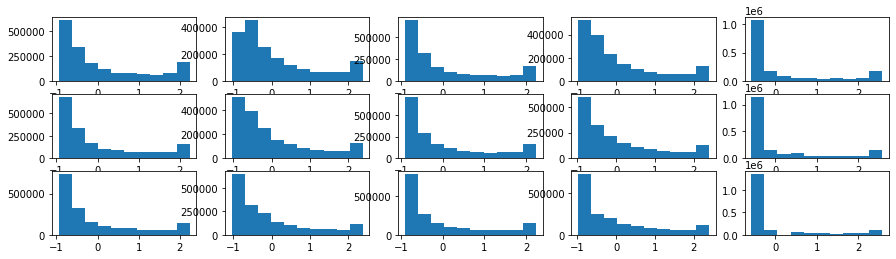

In [ ]:
fig, axs = plt.subplots(3,5, figsize = [15,4])
for index, ax in enumerate(axs.flatten()):
  ax.hist(xtrain[:,index])
# for index, ax in enumerate(axs[1,:].flatten()):
#   ax.hist(xtest[:,index])

In [ ]:
xtrain = xtrain.reshape([xtrain.shape[0]//3,3,5])
xtest = xtest.reshape([xtest.shape[0]//3,3,5])

In [ ]:
xtrain = xtrain[:,0,:2]
xtest = xtest[:,0,:2]

In [ ]:
xtrain = xtrain.reshape([xtrain.shape[0],15])
xtest = xtest.reshape([xtest.shape[0],15])

In [ ]:
xtrain = xtrain.reshape([xtrain.shape[0],3,5])
xtest = xtest.reshape([xtest.shape[0],3,5])

In [ ]:
# Features experiment
FR_mask = [0,1]
FF_mask=[2,3]
MF_mask=[4]
FR_FF_mask=[0,1,2,3]
FR_MF_mask=[0,1,4]
FF_MF_mask=[2,3,4]
FR_FF_MF=[0,1,2,3,4]
F_masks=[FR_mask,FF_mask,MF_mask,FR_FF_mask,FR_MF_mask,FF_MF_mask,FR_FF_MF]
F_masks_names=['FR_mask','FF_mask','MF_mask','FR_FF_mask','FR_MF_mask','FF_MF_mask','FR_FF_MF']

In [ ]:
#Exp 2 _ feature type
year_start_test = 2017
year_start_train = 2014
history_list = []
VERBOSE = 2
DATASIZE = 1*10**6

TEST_CALCULATED = False

for i in range(len(F_masks)):#[0,1,2,3,5,7,10]:
    FMASK = F_masks[i]
    
    for exp_num in range(5):
        if TEST_CALCULATED == False:
            xtrainorg,ytrainorg,xtest,ytest = preprocess_data(test_calculated = False)
        else:
            xtrainorg,ytrainorg,_,_ = preprocess_data(test_calculated = True)
        TEST_CALCULATED = True
        idxrnd = np.random.permutation(np.arange(len(xtrainorg)))
        xtrain=xtrainorg[idxrnd]
        ytrain=ytrainorg[idxrnd]

        NUM_OF_FEATURES = len(FMASK)
        hist, _ = train_nn()
        history_list.append([F_masks_names[i], exp_num, hist])

Cutoff degree: 1
Create Graph for  2011
    Done: Create Graph for  2011
    num of edges:  567838
Create Graph for  2014
    Done: Create Graph for  2014
    num of edges:  1844736
    Cutoff size: 1
    Potential pairs after cutoff: 1757213
    Number of pairs: 1757213
Data of year: 2011
Number of unconnected vertex pairs for prediction:  1000000
Number of vertex pairs that will be connected:  500000
Ratio of vertex pairs that will be connected:  0.5
Create Graph for  2014
    Done: Create Graph for  2014
    num of edges:  1844736
Create Graph for  2017
    Done: Create Graph for  2017
    num of edges:  5568240
Data of year: 2014
Number of unconnected vertex pairs for prediction:  1000000
Number of vertex pairs that will be connected:  3850
Ratio of vertex pairs that will be connected:  0.00385
    Created Graph Matrix for 2011-12 with 567755 edges
    Created Graph Matrix for 2010-12 with 374784 edges
    Created Graph Matrix for 2009-12 with 248079 edges
    Created Graph Matrix 

In [ ]:
#Exp 2 _ cuttoffs
year_start_test = 2017
year_start_train = 2014
history_list = []
VERBOSE = 1

TEST_CALCULATED = False
for i in [15,20,50,100]:#[0,1,2,3,5,7,10]:
    vertex_degree_cutoff = i
    
    for exp_num in range(5):
        if TEST_CALCULATED == False:
            xtrainorg,ytrainorg,xtest,ytest = preprocess_data(test_calculated = False)
        else:
            xtrainorg,ytrainorg,_,_ = preprocess_data(test_calculated = True)
        TEST_CALCULATED = True
        idxrnd = np.random.permutation(np.arange(len(xtrainorg)))
        xtrain=xtrainorg[idxrnd]
        ytrain=ytrainorg[idxrnd]

        # idxrnd = np.random.permutation(np.arange(len(xtestorg)))
        # xtest=xtestorg[idxrnd]
        # ytest=ytestorg[idxrnd]


        NUM_OF_FEATURES = 5
        hist = train_nn()
        history_list.append([vertex_degree_cutoff, exp_num, hist])